In [1]:
import sys, os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train

np.set_printoptions(linewidth=120)

In [4]:
parser = train.setup_standard_options(no_config=True)

args = parser.parse_args([])

args.no_test = True

args.device = 'cuda:0'
args.seed = 0

args.logdate = True
args.tblog = False
args.txtlog = False
args.saveroot = 'trained_nets'
args.save_freq = -1

args.dataset = 'svhn'
args.dataset = 'mnist'
# for emnist change link: 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
args.use_val = True
args.val_per = 1/6

args.num_workers = 4
args.batch_size = 128

args.start_epoch = 0
args.epochs = 10

args.name = 'test_on_mnist'


now = time.strftime("%y-%m-%d-%H%M%S")
if args.logdate:
    args.name = os.path.join(args.name, now)
args.save_dir = os.path.join(args.saveroot, args.name)
print('Save dir: {}'.format(args.save_dir))

if args.tblog or args.txtlog:
    util.create_dir(args.save_dir)
    print('Logging in {}'.format(args.save_dir))
logger = util.Logger(args.save_dir, tensorboard=args.tblog, txt=args.txtlog)

# Set seed
if not hasattr(args, 'seed') or args.seed is None:
    args.seed = util.get_random_seed()
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass

if not torch.cuda.is_available():
    args.device = 'cpu'
print('Using device {} - random seed set to {}'.format(args.device, args.seed))

Save dir: trained_nets/test_on_mnist/19-10-29-143809
Using device cuda:0 - random seed set to 0


In [5]:
datasets = train.load_data(args=args)
shuffles = [True, False, False]

loaders = [DataLoader(d, batch_size=args.batch_size, num_workers=args.num_workers) for d, s in zip(datasets, shuffles)]

trainloader, testloader = loaders[0], loaders[-1]
valloader = None if len(loaders) == 2 else loaders[1]

print('Input: {}, Output: {}'.format(args.din, args.dout))
print('traindata len={}, trainloader len={}'.format(len(datasets[0]), len(trainloader)))
if valloader is not None:
    print('valdata len={}, valloader len={}'.format(len(datasets[1]), len(valloader)))
print('testdata len={}, testloader len={}'.format(len(datasets[-1]), len(testloader)))
print('Batch size: {} samples'.format(args.batch_size))

Input: (1, 28, 28), Output: 10
traindata len=50000, trainloader len=391
valdata len=10000, valloader len=79
testdata len=10000, testloader len=79
Batch size: 128 samples


In [37]:
# Define Model
args.total_samples = {'train': 0, 'val':0, 'test': 0}
epoch = 0
best_loss = None
all_train_stats = []
all_val_stats = []
all_test_stats = []

args.din_flat = int(np.product(args.din))

class Simple(fd.Visualizable, fd.Trainable_Model):
    def __init__(self, net):
        super().__init__(args.din, args.dout)
        self.criterion = nn.MSELoss()
        self.net = net
        
        self.stats.new('confidence', 'accuracy')
        
    def forward(self, x):
        return self.net(x)
    
    def _visualize(self, info, logger=None):
        
        pick = info.pred.round()
        inv_conf = (info.pred - pick).abs().add(1e-4)
        confidence = (1./inv_conf).detach()
        
        correct = pick.long().sub(info.y).eq(0).float().detach()

        self.stats.update('confidence', confidence.mean())
        self.stats.update('accuracy', correct.mean())
    
    def _step(self, batch, out=None):
        if out is None:
            out = util.TensorDict()
            
        x,y = batch
        
        pred = self(x).squeeze()
        
        loss = self.criterion(pred, y.float())
        
        if self.train_me():
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
        out.loss = loss
        out.x = x
        out.y = y
        out.pred = pred
        return out
    

net = nn.Sequential(nn.Flatten(), models.make_MLP(args.din_flat, 1, hidden_dims=[300, 32, 32, 32], nonlin='prelu'))

model = Simple(net)
model.set_optim(optim_type='adam', lr=1e-3, weight_decay=1e-4, momentum=0.9)
scheduler = None#torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.2)

model.to(args.device)
print(model)
print(model.optim)
print('Model has {} parameters'.format(util.count_parameters(model)))

Simple(
  (criterion): MSELoss()
  (net): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=300, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=300, out_features=32, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=32, out_features=32, bias=True)
      (7): PReLU(num_parameters=1)
      (8): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0001
)
Model has 247281 parameters


In [38]:
# Reseed after model init
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass


if args.no_test:
    print('Will not run test data after training')
else:
    raise NotImplementedError

Will not run test data after training


In [39]:
for _ in range(args.epochs):

    model.reset()

    train_stats = util.StatsMeter()
    train_stats.shallow_join(model.stats)

    train_stats = train.run_epoch(model, trainloader, args, mode='train',
                                  epoch=epoch, print_freq=args.print_freq, logger=logger, silent=True,
                                  viz_criterion_args=args.viz_criterion_args,
                                  stats=train_stats, )

    all_train_stats.append(train_stats.copy())

    if valloader is not None:
        model.reset()

        val_stats = util.StatsMeter()
        val_stats.shallow_join(model.stats)

        val_stats = train.run_epoch(model, valloader, args, mode='val',
                                  epoch=epoch, print_freq=args.print_freq, logger=logger, silent=True,
                                  viz_criterion_args=args.viz_criterion_args,
                                  stats=val_stats, )

        all_val_stats.append(val_stats.copy())

    print('[ {} ] Epoch {} Train={:.3f} ({:.3f}), Val={:.3f} ({:.3f})'.format(
        time.strftime("%H:%M:%S"), epoch+1,
        train_stats['accuracy'].avg.item(), train_stats['loss'].avg.item(),
        val_stats['accuracy'].avg.item(), val_stats['loss'].avg.item(),
    ))

    if args.save_freq > 0 and epoch % args.save_freq == 0:


        ckpt = {
            'epoch': epoch+1,

            'args': args,

            'model_str': str(model),
            'model_state': model.state_dict(),
            'all_train_stats': all_train_stats,
        }
        if args.track_best:
            av_loss = train_stats['loss'].avg.item() if valloader is None else val_stats['loss'].avg.item()
            is_best = best_loss is None or av_loss < best_loss
            if is_best:
                best_loss = av_loss
                best_epoch = epoch

            ckpt['loss'] = av_loss
            ckpt['best_loss'] = best_loss
            ckpt['best_epoch'] = best_epoch
        if len(all_val_stats):
            ckpt['all_val_stats'] = all_val_stats
        path = save_checkpoint(ckpt, args.save_dir, is_best=is_best, epoch=epoch+1)
        print('--- checkpoint saved to {} ---'.format(path))

    epoch += 1

[ 14:53:51 ] Epoch 1 Train=0.334 (4.828), Val=0.334 (2.722)
[ 14:54:03 ] Epoch 2 Train=0.464 (2.186), Val=0.464 (1.472)
[ 14:54:14 ] Epoch 3 Train=0.597 (1.282), Val=0.597 (0.931)
[ 14:54:26 ] Epoch 4 Train=0.682 (0.864), Val=0.682 (0.658)
[ 14:54:37 ] Epoch 5 Train=0.740 (0.652), Val=0.740 (0.514)
[ 14:54:49 ] Epoch 6 Train=0.788 (0.520), Val=0.788 (0.417)
[ 14:55:01 ] Epoch 7 Train=0.832 (0.420), Val=0.832 (0.334)
[ 14:55:12 ] Epoch 8 Train=0.860 (0.342), Val=0.860 (0.269)
[ 14:55:24 ] Epoch 9 Train=0.879 (0.277), Val=0.879 (0.216)
[ 14:55:36 ] Epoch 10 Train=0.897 (0.227), Val=0.897 (0.179)


<IPython.core.display.Javascript object>


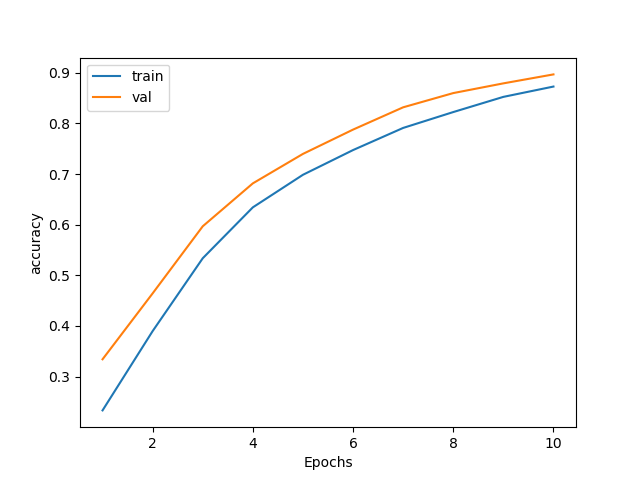

In [40]:
stat_key = 'accuracy'
figax = None
figax = util.plot_stat(all_train_stats, key=stat_key, figax=figax, label='train')
figax = util.plot_stat(all_val_stats, key=stat_key, figax=figax, label='val')
fig, ax = figax
plt.sca(ax)
plt.xlabel('Epochs')
plt.ylabel(stat_key)
plt.legend()

In [33]:
batch = next(iter(trainloader))
x, y = util.to(batch, device=args.device)
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [34]:
with torch.no_grad():
    pred = model(x)
    out = torch.cat([pred, pred.round(), y.float().unsqueeze(-1)],-1)
out

tensor([[ 4.2206e+00,  4.0000e+00,  5.0000e+00],
        [-3.2538e-01, -0.0000e+00,  0.0000e+00],
        [ 3.7486e+00,  4.0000e+00,  4.0000e+00],
        [ 1.1158e+00,  1.0000e+00,  1.0000e+00],
        [ 8.5993e+00,  9.0000e+00,  9.0000e+00],
        [ 1.0608e+00,  1.0000e+00,  2.0000e+00],
        [ 3.4046e-01,  0.0000e+00,  1.0000e+00],
        [ 3.1872e+00,  3.0000e+00,  3.0000e+00],
        [ 3.6781e-01,  0.0000e+00,  1.0000e+00],
        [ 3.1325e+00,  3.0000e+00,  4.0000e+00],
        [ 3.2305e+00,  3.0000e+00,  3.0000e+00],
        [ 4.1959e+00,  4.0000e+00,  5.0000e+00],
        [ 2.8323e+00,  3.0000e+00,  3.0000e+00],
        [ 6.2941e+00,  6.0000e+00,  6.0000e+00],
        [ 6.9245e-01,  1.0000e+00,  1.0000e+00],
        [ 7.2568e+00,  7.0000e+00,  7.0000e+00],
        [ 2.2825e+00,  2.0000e+00,  2.0000e+00],
        [ 7.7919e+00,  8.0000e+00,  8.0000e+00],
        [ 5.5944e+00,  6.0000e+00,  6.0000e+00],
        [ 9.0919e+00,  9.0000e+00,  9.0000e+00],
        [ 3.4527e+00

In [35]:
model.stats['accuracy'].avg

tensor(0.6938)

In [ ]:
model.stats['conf'].avg